# Analysis and Exploration of Wisconson Breast Cancer Data


In [4]:
import os
import pickle
import numpy as np
import pandas as pd
import numpy.linalg as npla
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, log_loss
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
import seaborn as sns


from pprint import pprint
%matplotlib inline

In [7]:
features = ['ID','label','avg_rad','avg_text','avg_peri','avg_area','avg_smooth',
            'avg_compact','avg_concav','avg_conc_p','avg_symm','avg_fractal',
            'se_rad','se_text','se_peri','se_area','se_smooth','se_compact',
            'se_concav','se_conc_p','se_symm','se_fractal','wor_rad', 'wor_text',
            'wor_peri','wor_area','wor_smooth','wor_compact', 'wor_concav',
            'wor_conc_p', 'wor_symm', 'wor_fractal']

label_map = {"M":1, "B":0}

In [8]:
df = pd.read_csv("data/wdbc.data", header=None)

df.columns = features
df['label'] = df['label'].map(label_map)
df.set_index("ID", drop=True, inplace=True)

y = df['label']
X = df.drop("label", axis=1)

In [9]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2)

### Exploratory Data Analysis


The data description for my chosen data set can be found [here.](http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names)

In our dataset, we have 3 broad groups of features, each of which is a different statistic for a given tumor measurement. 

The three broad groups are:
1. Average - denoted `avg`
2. Standard Error - denoted `se`
3. Worst (mean of the 3 largest values) - denoted `wor`


The 10 measurements we have are as follows:
1. radius (mean of distances from center to points on the perimeter) - denoted `_rad`
2. texture (standard deviation of gray-scale values) - denoted `_text`
3. perimeter - denoted `_peri`
4. area - denoted `_area`
5. smoothness (local variation in radius lengths) - denoted `_smooth`
6. compactness (perimeter^2 / area - 1.0) - denoted `_compact`
7. concavity (severity of concave portions of the contour) - denoted `_concav`
8. concave points (number of concave portions of the contour) - denoted `_conc_p`
9. symmetry - denoted `_symm`
10. fractal dimension ("coastline approximation" - 1) - denoted `_fractal`


All features are named according to: `<group><measurement>` in the dataframe used for this analysis

###### Class Balance
Below is the distribution of labels. `0` refers to a benign tumor, while `1` is malignant.

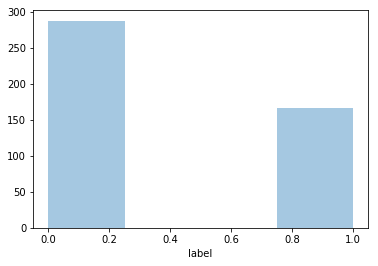

In [10]:
sns.distplot(y, kde=False)

C:\IntelPython3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


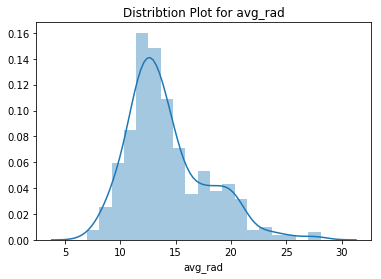

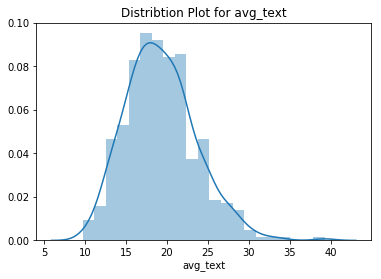

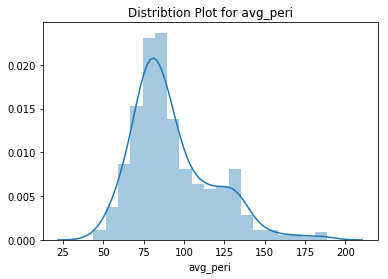

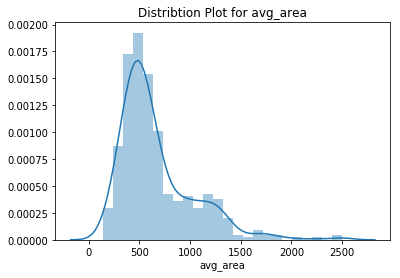

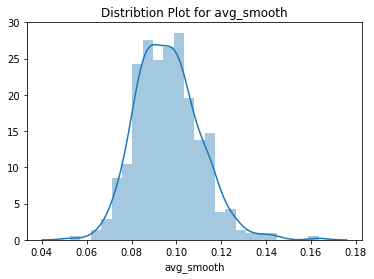

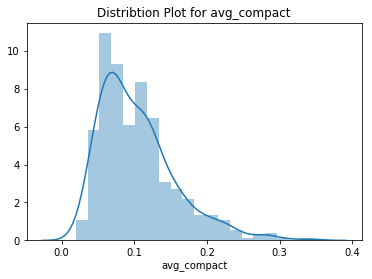

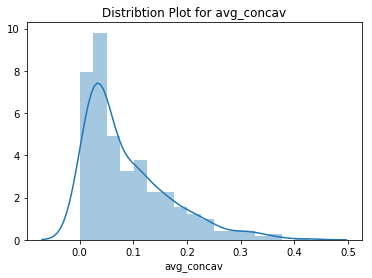

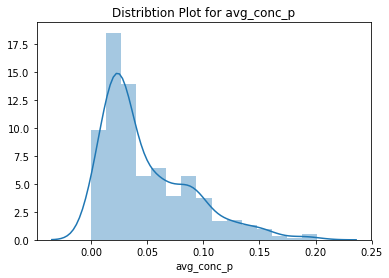

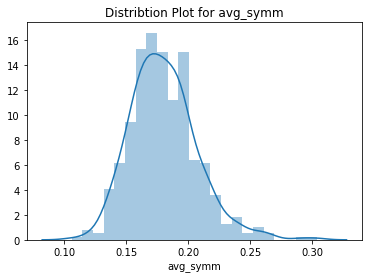

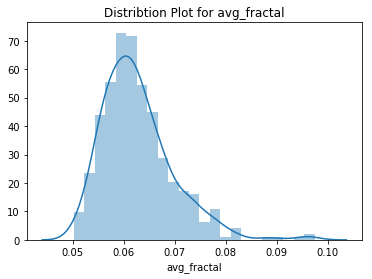

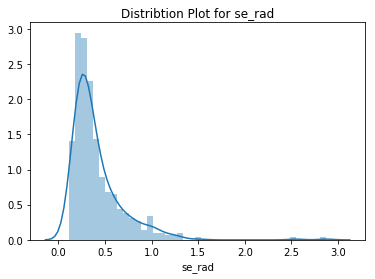

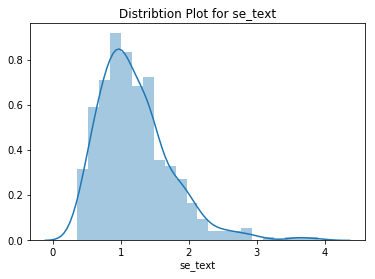

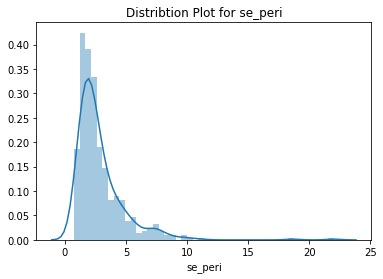

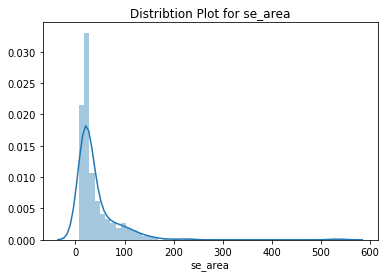

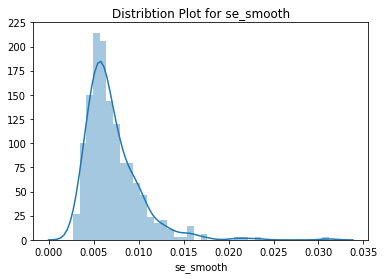

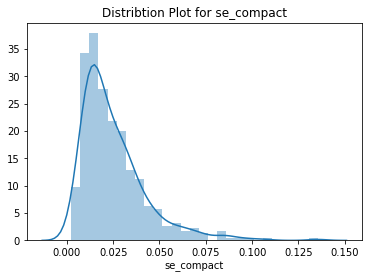

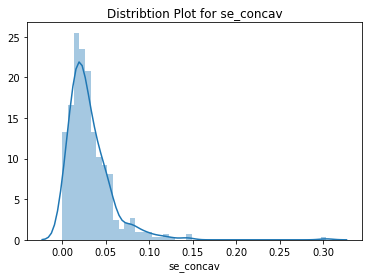

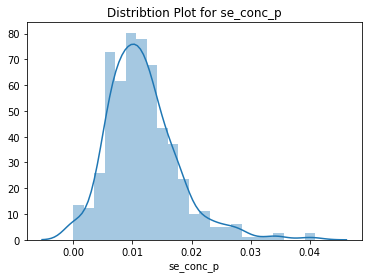

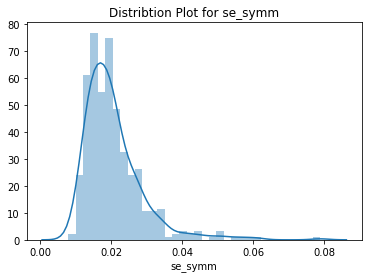

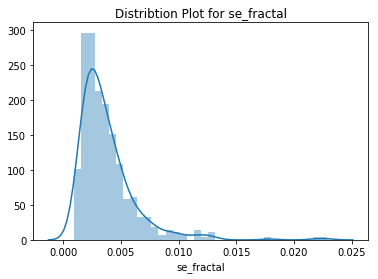

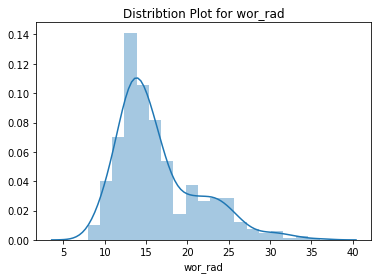

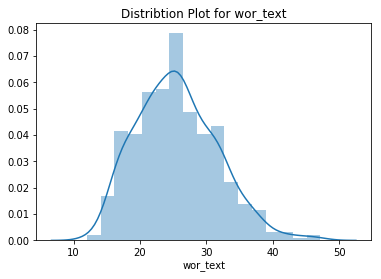

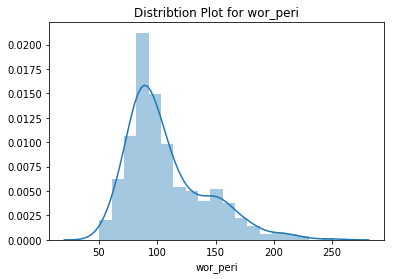

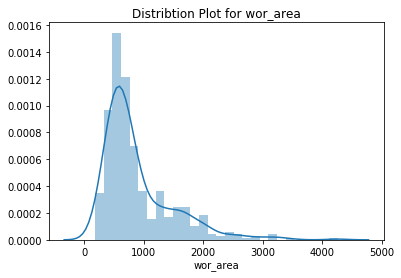

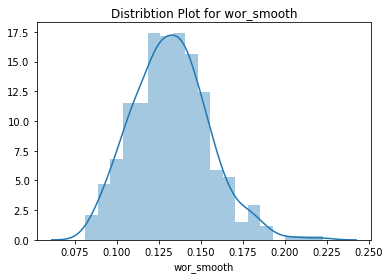

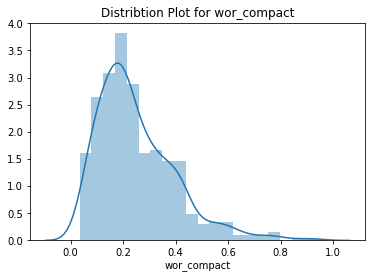

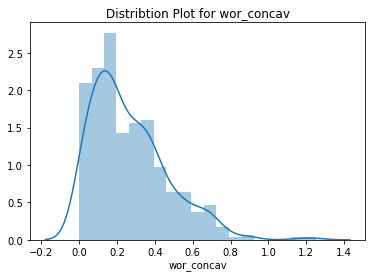

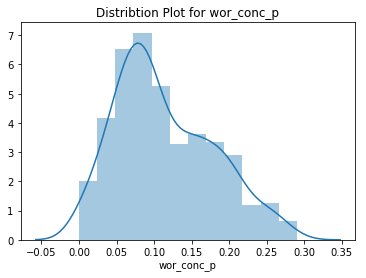

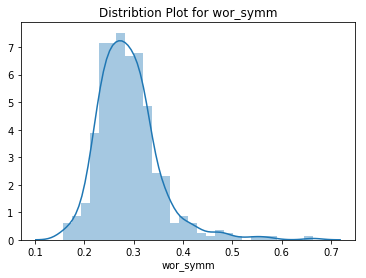

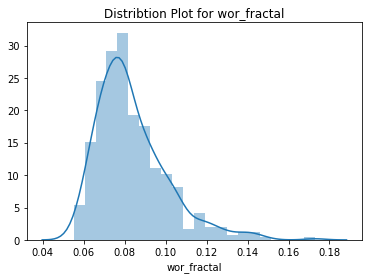

In [12]:
def EDA_distplots(df, feat_from, feat_to):
    for i in df.columns[feat_from:feat_to]:
        plt.figure(i)
        sns.distplot(df[i])
        plt.title("Distribtion Plot for {}".format(i))
        plt.ylabel("")
        
        
EDA_distplots(X, 0, 30)

##### Feature Distribution Plots

Above I have plotted histograms along with a kernel density estimate for each of our features in the dataset. Many of the above features appear to have normal, or lognormal distributions, except for radius, area, perimeter, and number of concave points which seem to be bi-modal.

In [13]:
Xt, Xv, yt, yv = train_test_split(X, y, test_size = 0.2)

###### Dimensionality Reduction and Visualization of the Full Dataset

Below I have reduced the dimensionality of this dataset using t-SNE, PCA, and Isomap. and to try and see if our classes were able to be separated well in a lower dimensional space. 

Nearly all of the visualizations below show some sort of identifiable structure in the lower dimensional space which allows us to separate the classes, but t-SNE and PCA are not particularly good at the boundary between the two classes, whereas Isomap performs much better. For this data, I prefer the Isomap visualization, because we could draw a pretty reasonable boundary between the two classes using only a vertical line. This tells me that the first Isomap coordinate contains quite a lot of useful information for classifying these points.

I also attempted to use a Gaussian Mixture model to cluster these points using 2 components, and was able to achieve quite low MSE on a validation set.

In [14]:
mean_squared_err = lambda y, yhat: np.mean((y-yhat)**2)

clust = GaussianMixture(n_components=2, covariance_type = 'full', tol=0.00001)
clust.fit(Xt)
clust.weights_
mean_squared_err(yv, clust.predict(Xv))

0.065934065934065936

In [15]:
def dim_scatter(model, x, title=None, xlabel=None, ylabel=None, cbar_labels=None, y=None, alpha=0.5):
    """
    Performs dimensionality reduction on a dataset, and plots the first two components of the transformed array. 
    If a y-value is specified, this is used to colour the points.
    
    Args:
        model (sklearn object): Initialized sklearn object for the dimensionality reduction to be performed. 
        x (ndarray): Input data to be transformed.
        title (str): Default=None. Argument to plt.title()
        xlabel (str): Default=None. Argument to plt.xlabel()
        ylabel (str): Default=None. Argument to plt.ylabel()
        cbar_labels (list): Default=None. Arguments to cbar.ax.set_yticklabels()        
        y (ndarray): Default=None. Becomes the colour of each point on the scatterplot.
        alpha (float): Default=0.5. Argument to plt.scatter()

    Returns:
        matplotlib.pyplot scatterplot of the lower dimensional space.
    
    """
    dimred = model.fit_transform(x)
    if y is not None:
        plt.scatter(x=dimred.T[0], y=dimred.T[1], c=y, alpha=alpha)
    else:
        plt.scatter(x=dimred.T[0], y=dimred.T[1], alpha=alpha)

    cbar = plt.colorbar()
    
    if cbar_labels:
        cbar.ax.set_yticklabels([cbar_labels[0],'','','','',cbar_labels[1]])          
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
                
    

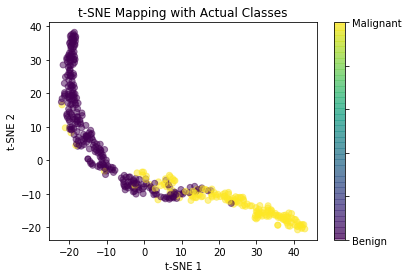

In [16]:
dimred_tsne = TSNE(n_components=2)

dim_scatter(dimred_tsne, X, "t-SNE Mapping with Actual Classes", "t-SNE 1", "t-SNE 2", ["Benign", "Malignant"], y=y)

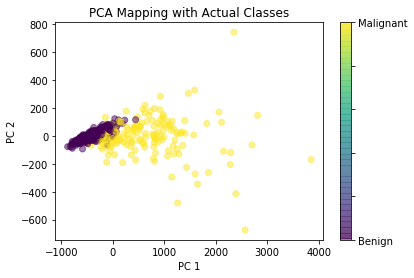

In [19]:
dimred_pca = PCA(n_components=2)

dim_scatter(dimred_pca, X, "PCA Mapping with Actual Classes", "PC 1", "PC 2", ["Benign", "Malignant"], y=y)

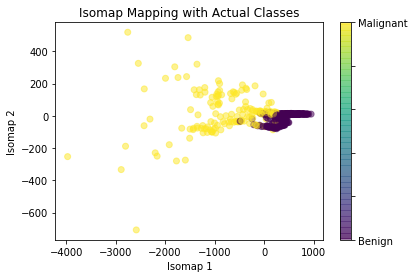

In [21]:
dimred_iso = Isomap(n_neighbors=10)

dim_scatter(dimred_iso, X, "Isomap Mapping with Actual Classes", "Isomap 1", "Isomap 2", ["Benign", "Malignant"], y=y)

### Feature Selection

Below I perform both LASSO and Elastic Net regresion in order to  select a number of important features from my dataset, and see how well a simple model performs using these selected features. One thing I am interested to see is if each of the 3 groups of measurements is equally important, or if there is a lot of repeated information within them. I am also interested to see if a measurement is not meaningful from one group, will it be meaningful in the others.

Once I have done this, I will look at how the features selected compare to those selected using RFE.

In [23]:
def plot_line(x, y, title=None, xlabel=None, ylabel=None):
    """
    Simple plotting utility to create a line graph.
    
    Args:
        x (list): Data to plot on the x-axis
        y (list): Data to plot on the y-axis
        title (str): Default=None. Argument to plt.title()
        xlabel (str): Default=None. Argument to plt.xlabel()
        ylabel (str): Default=None. Argument to plt.ylabel()
    
    Returns:
        matplotlib.pyplot line graph of the inputs.
    """
    
    plt.figure()
    plt.plot(x, y)
    plt.xscale('log')
    
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
        
        
def non_zeroes(model, x, y, feature_list):
    """
    Prints out each of the feature coefficients which are non-zero in the given model. Intended to be used after optimization of 
    the value for the regularization parameter.
        
    Args:
        model (sklearn Estimator): Initialized model you would like to identify nonzeros.
        x (ndarray): Array of features to train model on
        y (ndarray): Array of labels to train model on
        feature_list (list):
    
    Returns:
        A list of selected features
    
    Sources:
        https://stackoverflow.com/questions/21448225/getting-indices-of-true-values-in-a-boolean-list
    """
    
    model.fit(x, y)
    feat_names = list()
    nz_coefs = [i for i, x in enumerate(model.coef_ != 0) if x]
    for i in nz_coefs:
        feat_names.append(features[2:][i])
    
    return feat_names


def compare_selected(coefs1, coefs2):
    """
    Compares the features selected from two different methods.
    
    Args:
        coefs1 (list): List of Coefficients selected from the first method
        coefs2 (list): List of Coefficients selected from the second method
        
    Returns:
        List of the features occuring in both models.
    """
    inboth = list()
    if len(coefs1) >= len(coefs2):
        for feat in coefs1:
            if feat in coefs2:
                inboth.append(feat)
    
    else:
        for feat in coefs2:
            if feat in coefs1:
                inboth.append(feat)
                
    return inboth

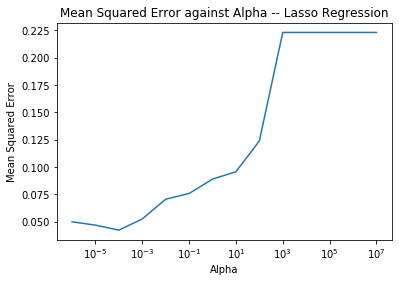

In [24]:
alphas = [10**-e for e in range(-7,7)]

mses = list()
nonzeroes = list()
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=50000)
    lasso.fit(Xt, yt)
    mses.append(mean_squared_err(yv, lasso.predict(Xv)))
    nonzeroes.append(sum(lasso.coef_!= 0))

    
plot_line(alphas, mses,
              title="Mean Squared Error against Alpha -- Lasso Regression", 
              xlabel="Alpha",
              ylabel="Mean Squared Error")    

The optimal value of alpha above appears to be $\alpha=0.0001$. Below I have printed out an array showing which of the features are non-zero

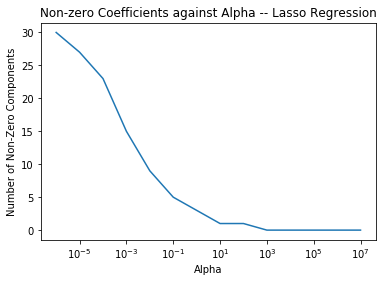

In [25]:
plot_line(alphas, nonzeroes, 
               title="Non-zero Coefficients against Alpha -- Lasso Regression", 
               xlabel="Alpha",
               ylabel="Number of Non-Zero Components")

In [26]:
lasso = Lasso(alpha=0.0001, max_iter=50000)


lasso_feats = non_zeroes(lasso, Xt, yt, features[2:])
pprint([i for i in lasso_feats])

['avg_rad',
 'avg_text',
 'avg_peri',
 'avg_area',
 'avg_compact',
 'avg_concav',
 'avg_conc_p',
 'avg_symm',
 'se_rad',
 'se_text',
 'se_peri',
 'se_area',
 'se_concav',
 'wor_rad',
 'wor_text',
 'wor_peri',
 'wor_area',
 'wor_smooth',
 'wor_compact',
 'wor_concav',
 'wor_conc_p',
 'wor_symm',
 'wor_fractal']


Above I have printed out the features which were non-zero in the above Lasso regression. 

A few things are interesting here. First of all, the average radius was deemed to be non-important, although the se_radius and worst radius were meaningful. The group with the most features selected (9/10) was the 'worst' group, which tells us that the averages of these tumor dimensions may not be as important to classification as the extremes are. 

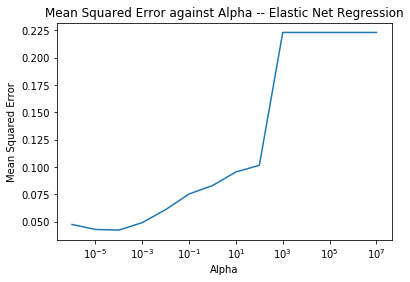

In [27]:
mses = list()
nonzeroes = list()
for alpha in alphas:
    en = ElasticNet(alpha=alpha, max_iter=50000)
    en.fit(Xt, yt)
    mses.append(mean_squared_err(yv, en.predict(Xv)))
    nonzeroes.append(sum(en.coef_!= 0))

    
plot_line(alphas, mses,
              title="Mean Squared Error against Alpha -- Elastic Net Regression", 
              xlabel="Alpha",
              ylabel="Mean Squared Error")  

As in the Lasso regression, it appears that our optimal alpha for Elastic Net is $\alpha=0.0001$

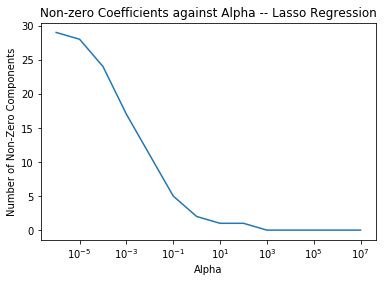

In [28]:
plot_line(alphas, nonzeroes, 
               title="Non-zero Coefficients against Alpha -- Lasso Regression", 
               xlabel="Alpha",
               ylabel="Number of Non-Zero Components")

In [29]:
en = ElasticNet(alpha=0.0001, max_iter=30000)

en_feats = non_zeroes(en, Xt, yt, features[2:])
pprint([i for i in en_feats])

['avg_text',
 'avg_peri',
 'avg_area',
 'avg_compact',
 'avg_concav',
 'avg_conc_p',
 'avg_symm',
 'se_rad',
 'se_text',
 'se_peri',
 'se_area',
 'se_smooth',
 'se_concav',
 'se_symm',
 'wor_rad',
 'wor_text',
 'wor_peri',
 'wor_area',
 'wor_smooth',
 'wor_compact',
 'wor_concav',
 'wor_conc_p',
 'wor_symm',
 'wor_fractal']


In [30]:
print("""The number of features shared by both methods is: {}

The number of features selected by Elastic Net is: {}
         
The number of features selected by Lasso is: {}""".format(len(compare_selected(en_feats, lasso_feats)), len(en_feats), len(lasso_feats)))

The number of features shared by both methods is: 22

The number of features selected by Elastic Net is: 24
         
The number of features selected by Lasso is: 23


We can see above that the Elastic Net selects all featuers that were in the Lasso model, as well as some additional one. This is likely due to the mixed L1 and L2 regularization that Elastic Net performs, which attempts to make coeffecients tend towards 0, and not be exactly 0 as much as Lasso does.


In [31]:
lasso.fit(Xt, yt)
en.fit(Xt, yt)

print("""Validation Mean Squared Error for Lasso was: {}
Validation Mean Squared Error for Elastic Net was: {}"""
      .format(mean_squared_err(yv, lasso.predict(Xv)), mean_squared_err(yv, en.predict(Xv))))



print("""
Testing Mean Squared Error for Lasso was: {}
Testing Mean Squared Error for Elastic Net was: {}"""
      .format(mean_squared_err(y_test, lasso.predict(X_test)), mean_squared_err(y_test, en.predict(X_test))))


Validation Mean Squared Error for Lasso was: 0.04215314277023711
Validation Mean Squared Error for Elastic Net was: 0.04237556803369518

Testing Mean Squared Error for Lasso was: 0.07064609961025403
Testing Mean Squared Error for Elastic Net was: 0.07037149406952052


It turns out that our MSE is actually slightly lower for the validation set when using the Lasso model, although Elastic Net performs slightly better on the test set. We will start by using the Lasso subset of features  in the next steps. Below we will start to select a particular type of model for our classification.

### Model Selection -- k-NN vs. Random Forests

The first step below is to scale our X data in order to pass it to the `KNeighborsClassifier`, since k-NN is sensitive to the variance of our features. Random Forests are scale invariant, and so this should have no impact on the Random Forest's performance.

In [32]:
X_20 = X[lasso_feats]
X_20test = X_test[lasso_feats]

scaler20 = StandardScaler()

scaler20.fit(X_20)

X20_scaled = scaler20.transform(X_20)

X20test_scaled = scaler20.transform(X_20test)

X20t, X20v, y20t, y20v = train_test_split(X20_scaled, y, test_size = 0.2)


X_25 = X[en_feats]
X_25test = X_test[en_feats]

scaler25 = StandardScaler()

scaler25.fit(X_25)

X25_scaled = scaler25.transform(X_25)

X25test_scaled = scaler25.transform(X_25test)

X25t, X25v, y25t, y25v = train_test_split(X25_scaled, y, test_size = 0.2)


##### k-Nearest Neighbours

First we will use the 20 selected features from Lasso

In [33]:
knn20_clf = KNC()
param_dict20 = {"n_neighbors": [i for i in range(2,51)]}

knn20_cv = GridSearchCV(knn20_clf, param_dict20)
knn20_cv.fit(X20_scaled, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [34]:
print("""The optimal number of neighbours to use according to cross validation is: {1}

This results in a cross validation accuracy of: {0}

Accuracy on the test set is: {2}""".format(knn20_cv.best_score_, knn20_cv.best_params_['n_neighbors'], knn20_cv.score(X20test_scaled, y_test)))

The optimal number of neighbours to use according to cross validation is: 3

This results in a cross validation accuracy of: 0.967032967032967

Accuracy on the test set is: 0.9385964912280702


Now we will try with the features selected from Elastic Net

In [35]:
knn25_clf = KNC()
param_dict25= {"n_neighbors": [i for i in range(2,51)]}

knn25_cv = GridSearchCV(knn25_clf, param_dict25)
knn25_cv.fit(X25_scaled, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [36]:
print("""The optimal number of neighbours to use according to cross validation is: {1}

This results in a cross validation accuracy of: {0}

Accuracy on the test set is: {2}""".format(knn25_cv.best_score_, knn25_cv.best_params_['n_neighbors'], knn25_cv.score(X25test_scaled, y_test)))

The optimal number of neighbours to use according to cross validation is: 3

This results in a cross validation accuracy of: 0.9692307692307692

Accuracy on the test set is: 0.9473684210526315


##### Random Forests

First, we will use the features selected from Lasso.

In [37]:
rfc20_clf = RFC()
param_dict20 = {"max_depth": [i for i in range(1,25)], "max_features": [i for i in range(1, len(lasso_feats))]}

rfc20_cv = GridSearchCV(rfc20_clf, param_dict20)
rfc20_cv.fit(X20_scaled, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [38]:
print("""The optimal depth to use according to cross validation is: {1}

The optimal maximum number of features is: {2}

This results in a cross validation accuracy of: {0}

MSE on the test set is: {3}""".format(rfc20_cv.best_score_, rfc20_cv.best_params_['max_depth'], rfc20_cv.best_params_['max_features'], mean_squared_err(y_test, rfc20_cv.predict(X20test_scaled))))

The optimal depth to use according to cross validation is: 15

The optimal maximum number of features is: 3

This results in a cross validation accuracy of: 0.9692307692307692

MSE on the test set is: 0.06140350877192982


I will now attempt to fit the same model on the features selected by Elastic Net

In [39]:
rfc25_clf = RFC()
param_dict25 = {"max_depth": [i for i in range(1,25)], "max_features": [i for i in range(1, len(en_feats))]}

rfc25_cv = GridSearchCV(rfc25_clf, param_dict25)
rfc25_cv.fit(X25_scaled, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [40]:
print("""The optimal depth to use according to cross validation is: {1}

The optimal maximum number of features is: {2}

This results in a cross validation accuracy of: {0}

MSE for the test set is: {3}""".format(rfc25_cv.best_score_, rfc25_cv.best_params_['max_depth'], rfc25_cv.best_params_['max_features'], mean_squared_err(y_test, rfc25_cv.predict(X25test_scaled))))

The optimal depth to use according to cross validation is: 13

The optimal maximum number of features is: 1

This results in a cross validation accuracy of: 0.9692307692307692

MSE for the test set is: 0.08771929824561403


The above model according to the features selected by Elastic Net appears to be quite unstable, so I think the features selected from Lasso are preferrable, and in fact, using fewer features here scores better on the test set.

Since our model appears relatively unstable with so many features, and we are not actually using them all in the random forest; I will perform another round of feature selection to narrow my used features to the 5 most important ones, which may be of interest to oncologists in order to identify the most reliable indicators of malignant tumors

In [73]:
def selected_feats(model, x, y, feature_list):
    """
    Prints out each of the feature coefficients which are selected by pruning features using RFE with the given model. 
    I
        
    Args:
        model (sklearn Estimator): Initialized model you would like to identify nonzeros.
        x (ndarray): Array of features to train model on
        y (ndarray): Array of labels to train model on
        feature_list (list): list of features from the dataframe to use in this selection
    
    Returns:
        A list of the selected features
    
    Sources:
        https://stackoverflow.com/questions/21448225/getting-indices-of-true-values-in-a-boolean-list
    """
    
    model.fit(x, y)
    feat_names = list()
    selected = [i for i, x in enumerate(model.ranking_ == 1) if x]
    for i in selected:
        feat_names.append(X[feature_list].columns[i])
    
    return feat_names

In [88]:
rfe_rfc = RFE(RFC(), n_features_to_select=5)

rfe_lasso = selected_feats(rfe_rfc, X_20, y, lasso_feats)
print(rfe_lasso)

['avg_conc_p', 'wor_rad', 'wor_peri', 'wor_area', 'wor_conc_p']


In [89]:
rfe_en = selected_feats(rfe_rfc, X_25, y, en_feats)
print(rfe_en)

['avg_concav', 'avg_conc_p', 'wor_peri', 'wor_area', 'wor_conc_p']


The above RFE feature selection is performed using a default Random Forest Classifier. We select slightly different features if we use the Lasso results as opposed to the Elastic Net ones. We will now look at the results from each of the two optimal feature sets.

In [90]:
rfe_rfc = RFC()

rfe_rfc.fit(X_20[rfe_lasso], y)

print("Test error using the 5 selected features is: {}".format(mean_squared_err(y_test, rfe_rfc.predict(X_20test[rfe_lasso]))))

Test error using the 5 selected features is: 0.05263157894736842


In [91]:
rfe_rfc = RFC()

rfe_rfc.fit(X_25[rfe_en], y)

print("Test error using the 5 selected features is: {}".format(mean_squared_err(y_test, rfe_rfc.predict(X_25test[rfe_en]))))

Test error using the 5 selected features is: 0.07017543859649122


We can see above that the parameters selected from the Lasso regression perform better than those from Elastic Net on the test set.

The main difference is that with the features from Elastic Net, RFE tends to pick average concavity as well as the average number of concave points, and does not select the worst radius, as RFE does with Lasso. While the MSE is not much different between the models, in most instances, the features selected from the Lasso model perform better.